In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#2.6s

Hash numérica de 5 dígitos: 94799


In [2]:
timeline_file = 'src/data/timeline.csv'
days_file = 'src/data/days.csv'
timeline_df = pd.read_csv(timeline_file)
days_df = pd.read_csv(days_file)
merged_df = pd.merge(timeline_df, days_df, on='ID do contrato', how='left')
merged_df["Quantidade de horas que o contrato sofreu postergação de inicio"].isna().mean()

np.float64(0.554543169124157)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def gerar_grafico_cancelamentos_por_adiamentos(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    data_format = '%Y-%m-%d %H:%M:%S'
    timeline_df['Data da criação do contrato'] = pd.to_datetime(timeline_df['Data da criação do contrato'], format=data_format, errors='coerce')
    timeline_df['data do evento'] = pd.to_datetime(timeline_df['data do evento'], format=data_format, errors='coerce')

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    df_tipo = df_tipo.dropna(subset=['Data da criação do contrato', 'data do evento'])

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['cancelado'] = merged_df['Nome do evento ocorrido no contrato'] == 'canceled'

    adiamentos_df = merged_df.groupby('ID do contrato')['Nome do evento ocorrido no contrato'].count().reset_index()
    adiamentos_df.rename(columns={'Nome do evento ocorrido no contrato': 'quantidade_adiamentos'}, inplace=True)
    merged_df = pd.merge(merged_df, adiamentos_df, on='ID do contrato', how='left')

    cancelamentos_por_adiamento = merged_df.groupby('quantidade_adiamentos')['cancelado'].mean()
    print(f"\n[{tipo_contrato}] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos")
    print(cancelamentos_por_adiamento.reset_index())

    cancelamentos_por_adiamento.plot(kind='bar', color='skyblue')
    plt.title(f'[{tipo_contrato}] Cancelamentos por Adiamentos')
    plt.xlabel('Quantidade de Adiamentos')
    plt.ylabel('Proporção de Cancelamentos')
    plt.xticks(rotation=0)
    plt.xlim([0, 10])
    plt.tight_layout()
    plt.show()


def gerar_grafico_ciclo_de_vida(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    data_format = '%Y-%m-%d %H:%M:%S'
    df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
    df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['tempo_decorrido'] = (merged_df['data do evento'] - merged_df['Data da criação do contrato']).dt.total_seconds() / 3600
    janelas = list(range(6, 7*24, 6))

    status = {
        'freight_completed': 'Atendido',
        'canceled': 'Cancelado',
        'start_at_change': 'Postergado'
    }

    N = merged_df["ID do contrato"].nunique()
    proporcoes = {nome: [] for nome in status.values()}

    for janela in janelas:
        df_janela = merged_df[merged_df['tempo_decorrido'] <= janela]
        for evento, nome_legivel in status.items():
            df_evento = df_janela[df_janela['Nome do evento ocorrido no contrato'] == evento]
            if evento == 'start_at_change':
                df_evento = df_evento[df_evento['Quantidade de horas que o contrato sofreu postergação de inicio'].notna()]
            df_evento_unique = df_evento.drop_duplicates(subset='ID do contrato')
            proporcao = len(df_evento_unique) / N
            proporcoes[nome_legivel].append(proporcao)

    df_resultado = pd.DataFrame(proporcoes, index=janelas)
    print(f"\n[{tipo_contrato}] Tabela: Ciclo de Vida dos Contratos")
    print(df_resultado)

    df_resultado.plot(kind='bar', figsize=(12, 6))
    plt.title(f'[{tipo_contrato}] Ciclo de Vida dos Contratos por Janela Temporal')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Proporção de Contratos')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return df_resultado


def gerar_grafico_distribuicao_adiamentos(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato]
    data_format = '%Y-%m-%d %H:%M:%S'
    df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
    df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df = merged_df.dropna(subset=['Quantidade de horas que o contrato sofreu postergação de inicio'])

    janelas = [6, 12, 18, 24, float('inf')]
    nomes_janelas = ['Até 6 horas', '6-12 horas', '12-18 horas', '18-24 horas', '24+ horas']

    contagens = []
    for i, janela in enumerate(janelas):
        if janela == float('inf'):
            contagem = len(merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]])
        else:
            if i == 0:
                contagem = len(merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela])
            else:
                contagem = len(merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                         (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela)])
        contagens.append(contagem)

    df = pd.DataFrame({'Janela': nomes_janelas, 'Total de Adiamentos': contagens})
    print(f"\n[{tipo_contrato}] Tabela: Distribuição dos Adiamentos")
    print(df)

    plt.bar(nomes_janelas, contagens, color='orange')
    plt.title(f'[{tipo_contrato}] Distribuição dos Adiamentos')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Total de Adiamentos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def gerar_grafico_proporcao_cancelamentos_por_adiantamento(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    data_format = '%Y-%m-%d %H:%M:%S'
    timeline_df['Data da criação do contrato'] = pd.to_datetime(timeline_df['Data da criação do contrato'], format=data_format, errors='coerce')
    timeline_df['data do evento'] = pd.to_datetime(timeline_df['data do evento'], format=data_format, errors='coerce')

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    df_tipo = df_tipo.dropna(subset=['Data da criação do contrato', 'data do evento'])

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['cancelado'] = merged_df['Nome do evento ocorrido no contrato'] == 'canceled'

    janelas = [6, 12, 18, 24, float('inf')]
    nomes_janelas = ['Até 6 horas', '6-12 horas', '12-18 horas', '18-24 horas', '24+ horas']
    proporcoes_cancelamento = {}

    for i, janela in enumerate(janelas):
        nome_janela = nomes_janelas[i]
        if janela == float('inf'):
            contratos_com_adiamento = merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]]['ID do contrato'].unique()
            contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) & (merged_df['cancelado'])]['ID do contrato'].unique()
        else:
            if i == 0:
                contratos_com_adiamento = merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela]['ID do contrato'].unique()
                contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela) & (merged_df['cancelado'])]['ID do contrato'].unique()
            else:
                contratos_com_adiamento = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                                    (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela)]['ID do contrato'].unique()
                contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                                 (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela) &
                                                 (merged_df['cancelado'])]['ID do contrato'].unique()

        total_contratos_com_adiamento = len(contratos_com_adiamento)
        total_contratos_cancelados = len(contratos_cancelados)
        proporcao = total_contratos_cancelados / total_contratos_com_adiamento if total_contratos_com_adiamento > 0 else 0
        proporcoes_cancelamento[nome_janela] = proporcao

    df = pd.DataFrame(list(proporcoes_cancelamento.items()), columns=['Janela', 'Proporção de Cancelamentos'])
    print(f"\n[{tipo_contrato}] Tabela: Proporção de Cancelamentos por Janela de Adiantamento")
    print(df)

    plt.bar(df['Janela'], df['Proporção de Cancelamentos'], color='red')
    plt.title(f'[{tipo_contrato}] Cancelamentos por Janela de Adiantamento')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Proporção de Cancelamentos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



[Diária] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos
     quantidade_adiamentos  cancelado
0                        2   0.000000
1                        3   0.066381
2                        4   0.241592
3                        5   0.191774
4                        6   0.092056
5                        7   0.104445
6                        8   0.004667
7                        9   0.010375
8                       10   0.012800
9                       11   0.011174
10                      12   0.012555
11                      13   0.008578
12                      14   0.021757
13                      15   0.005349
14                      16   0.033822
15                      17   0.008069
16                      18   0.052347
17                      19   0.005371
18                      20   0.042446
19                      21   0.021645
20                      22   0.032119
21                      23   0.008282
22                      24   0.021547
23            

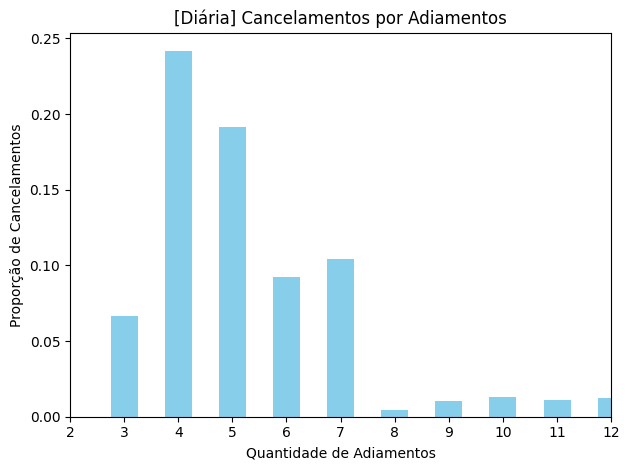


[Diária] Tabela: Ciclo de Vida dos Contratos
     Atendido  Cancelado  Postergado
6    0.184668   0.058831    0.044123
12   0.238641   0.068886    0.056046
18   0.329624   0.083039    0.075577
24   0.409806   0.106933    0.105438
30   0.437847   0.120351    0.121376
36   0.451338   0.123883    0.124486
42   0.480898   0.129188    0.130080
48   0.515666   0.140327    0.139290
54   0.527818   0.147344    0.145318
60   0.536498   0.149007    0.146427
66   0.569892   0.153359    0.150912
72   0.598669   0.162377    0.159785
78   0.606011   0.168308    0.164438
84   0.609905   0.169622    0.165451
90   0.627000   0.171949    0.167778
96   0.642069   0.176675    0.172250
102  0.645421   0.180316    0.174770
108  0.647084   0.181304    0.175059
114  0.655282   0.182968    0.176385
120  0.663902   0.186850    0.178543
126  0.665915   0.189044    0.179858
132  0.667036   0.189490    0.180062
138  0.673064   0.190852    0.180629
144  0.679273   0.193444    0.181955
150  0.680478   0.195036    0

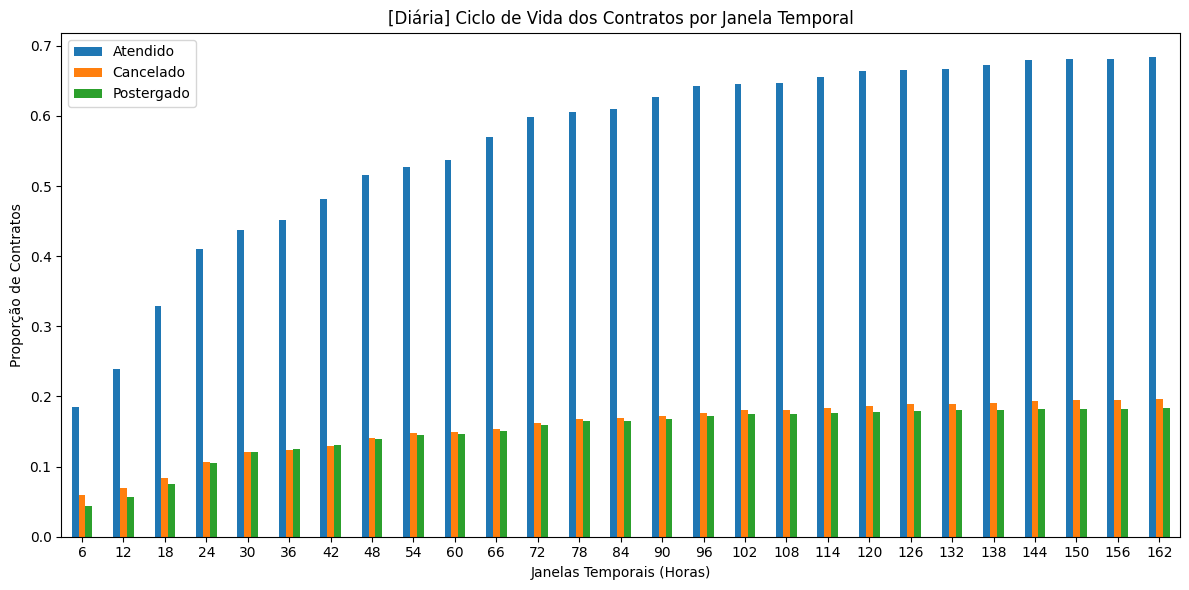

/tmp/ipykernel_31497/2047966146.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
/tmp/ipykernel_31497/2047966146.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')



[Diária] Tabela: Distribuição dos Adiamentos
        Janela  Total de Adiamentos
0  Até 6 horas                61289
1   6-12 horas                19473
2  12-18 horas                19788
3  18-24 horas               188692
4    24+ horas               148364


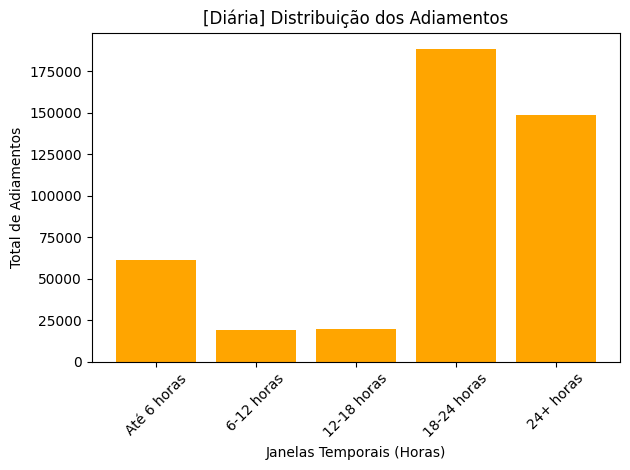


[Diária] Tabela: Proporção de Cancelamentos por Janela de Adiantamento
        Janela  Proporção de Cancelamentos
0  Até 6 horas                    0.224859
1   6-12 horas                    0.219157
2  12-18 horas                    0.233469
3  18-24 horas                    0.339154
4    24+ horas                    0.316908


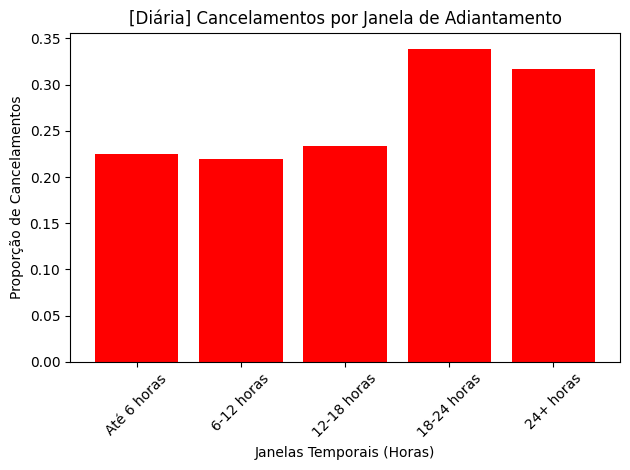


[Coleta/Entrega] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos
     quantidade_adiamentos  cancelado
0                        2   0.000000
1                        3   0.000000
2                        4   0.249467
3                        5   0.197078
4                        6   0.131124
5                        7   0.117106
6                        8   0.002988
7                        9   0.007769
8                       10   0.010603
9                       11   0.011085
10                      12   0.013438
11                      13   0.006711
12                      14   0.017115
13                      15   0.005306
14                      16   0.041858
15                      17   0.004202
16                      18   0.061404
17                      19   0.005263
18                      20   0.061905
19                      21   0.031746
20                      22   0.040727
21                      23   0.000000
22                      24   0.034167
23    

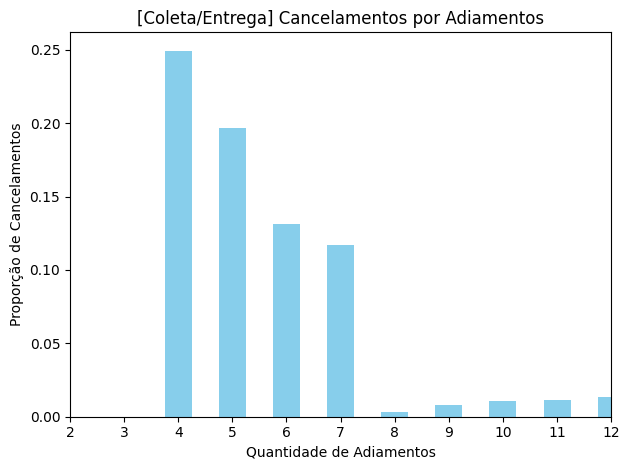


[Coleta/Entrega] Tabela: Ciclo de Vida dos Contratos
     Atendido  Cancelado  Postergado
6    0.144066   0.050832    0.022209
12   0.230322   0.060985    0.030863
18   0.473327   0.079438    0.057504
24   0.542677   0.100728    0.081679
30   0.551589   0.110866    0.090430
36   0.563757   0.113315    0.092864
42   0.613428   0.118279    0.097441
48   0.660070   0.126289    0.104774
54   0.664663   0.131447    0.109383
60   0.673882   0.132784    0.111011
66   0.721441   0.136701    0.114637
72   0.744343   0.141858    0.120923
78   0.746970   0.145887    0.123598
84   0.750355   0.146709    0.124484
90   0.765601   0.148337    0.126128
96   0.775126   0.152237    0.128562
102  0.776673   0.154235    0.129916
108  0.778075   0.154832    0.130254
114  0.784844   0.156169    0.130995
120  0.789228   0.158184    0.132285
126  0.789888   0.160086    0.132881
132  0.790565   0.160698    0.133203
138  0.793692   0.161714    0.133429
144  0.796400   0.163519    0.134058
150  0.796819   0.164

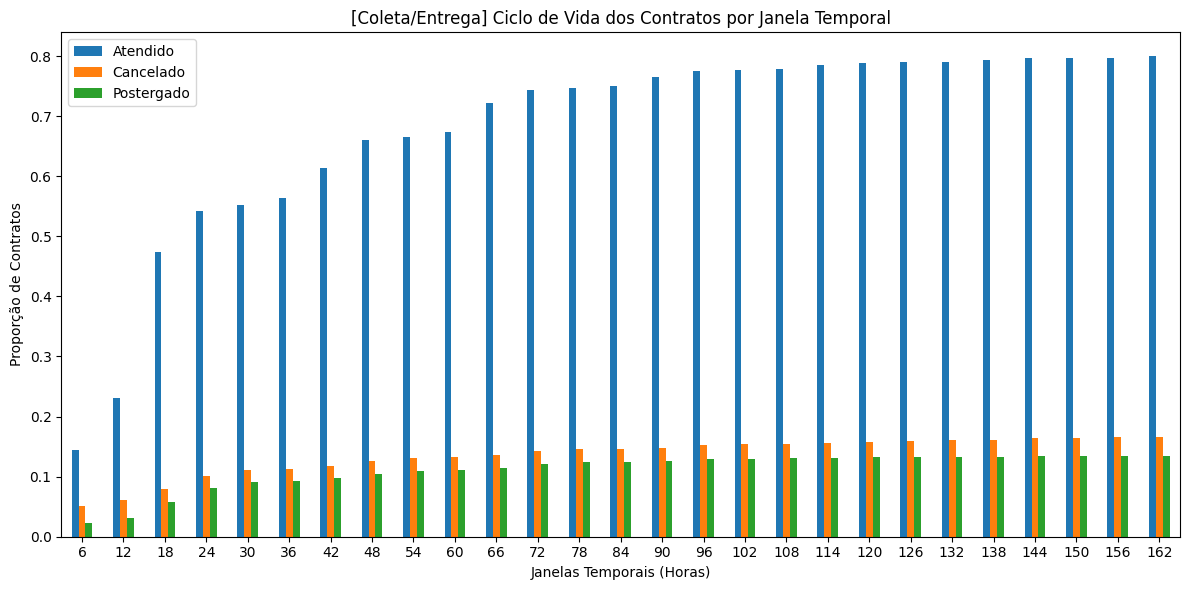

/tmp/ipykernel_31497/2047966146.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
/tmp/ipykernel_31497/2047966146.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')



[Coleta/Entrega] Tabela: Distribuição dos Adiamentos
        Janela  Total de Adiamentos
0  Até 6 horas                20123
1   6-12 horas                 5407
2  12-18 horas                 3074
3  18-24 horas               150277
4    24+ horas                73674


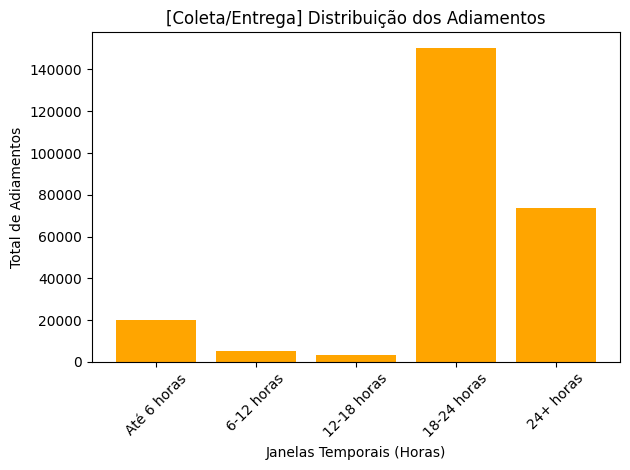


[Coleta/Entrega] Tabela: Proporção de Cancelamentos por Janela de Adiantamento
        Janela  Proporção de Cancelamentos
0  Até 6 horas                    0.310976
1   6-12 horas                    0.155263
2  12-18 horas                    0.199029
3  18-24 horas                    0.380836
4    24+ horas                    0.381700


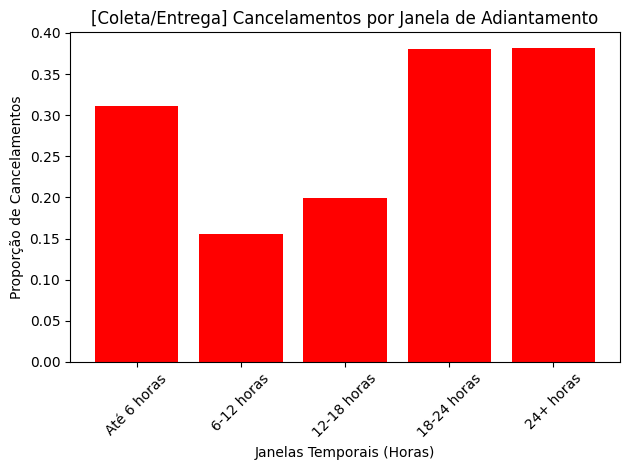


[Ajudante] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos
     quantidade_adiamentos  cancelado
0                        2   0.000000
1                        3   0.000000
2                        4   0.248872
3                        5   0.195282
4                        6   0.137044
5                        7   0.106633
6                        8   0.009470
7                        9   0.019087
8                       10   0.023557
9                       11   0.021228
10                      12   0.029882
11                      13   0.016266
12                      14   0.033256
13                      15   0.012766
14                      16   0.041322
15                      17   0.010804
16                      18   0.064599
17                      19   0.012146
18                      20   0.065000
19                      21   0.113757
20                      22   0.035915
21                      23   0.043478
22                      24   0.055707
23          

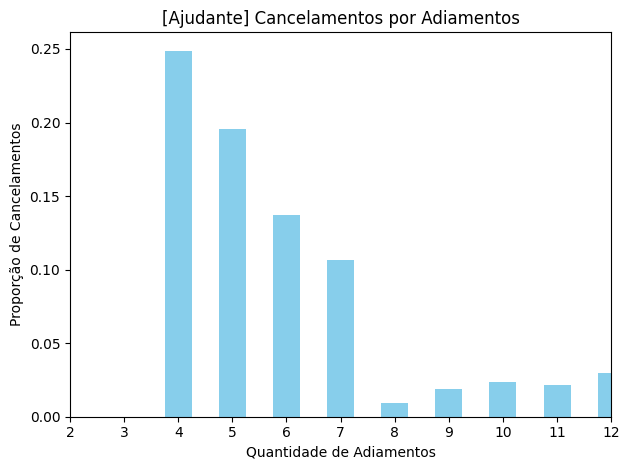


[Ajudante] Tabela: Ciclo de Vida dos Contratos
     Atendido  Cancelado  Postergado
6    0.078968   0.069966    0.051659
12   0.159869   0.088514    0.065978
18   0.288804   0.117213    0.100779
24   0.355326   0.151955    0.136366
30   0.378467   0.175699    0.155821
36   0.398586   0.182345    0.161561
42   0.428796   0.189837    0.166214
48   0.453447   0.205003    0.175820
54   0.464806   0.213582    0.182406
60   0.475742   0.216845    0.185487
66   0.505226   0.226572    0.191710
72   0.526917   0.238354    0.201317
78   0.535617   0.248142    0.206090
84   0.540511   0.251405    0.209111
90   0.556341   0.256057    0.212857
96   0.567398   0.265603    0.217268
102  0.571748   0.272370    0.220712
108  0.574346   0.274122    0.221135
114  0.582261   0.277143    0.223189
120  0.586732   0.282219    0.226814
126  0.589149   0.286085    0.228627
132  0.591565   0.286871    0.229291
138  0.596399   0.289529    0.230016
144  0.600508   0.293215    0.232010
150  0.601655   0.297203   

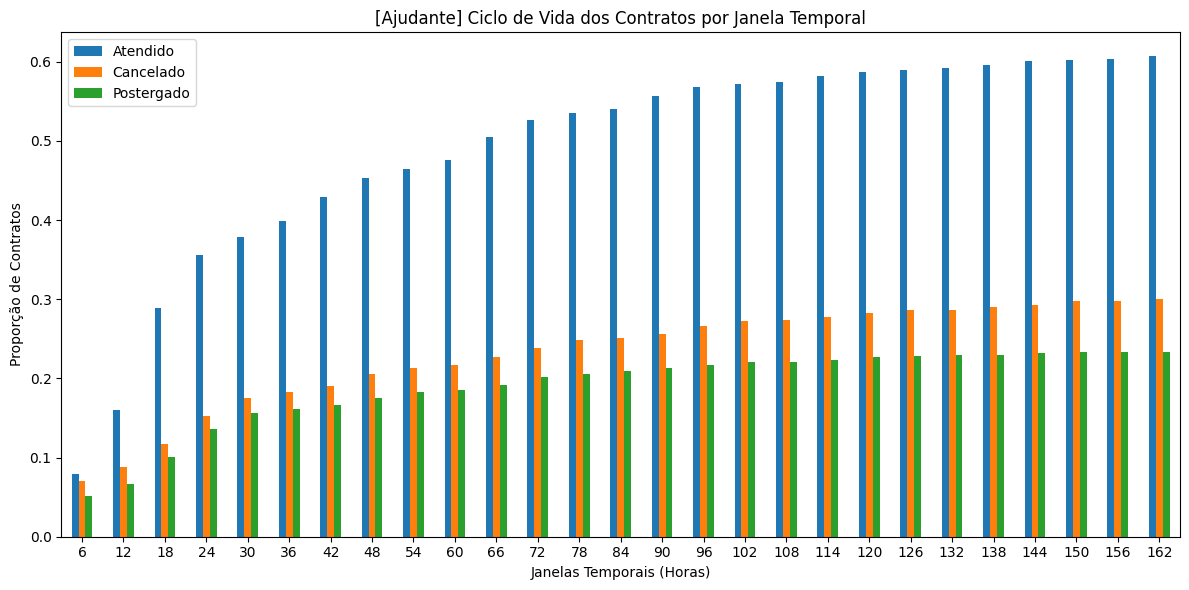


[Ajudante] Tabela: Distribuição dos Adiamentos
        Janela  Total de Adiamentos
0  Até 6 horas                 8925
1   6-12 horas                 3486
2  12-18 horas                 5043
3  18-24 horas                63998
4    24+ horas                43475


/tmp/ipykernel_31497/2047966146.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
/tmp/ipykernel_31497/2047966146.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')


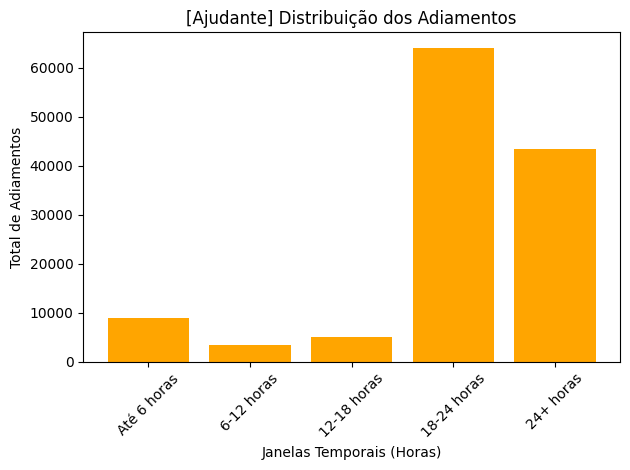


[Ajudante] Tabela: Proporção de Cancelamentos por Janela de Adiantamento
        Janela  Proporção de Cancelamentos
0  Até 6 horas                    0.450704
1   6-12 horas                    0.279661
2  12-18 horas                    0.320557
3  18-24 horas                    0.440115
4    24+ horas                    0.429283


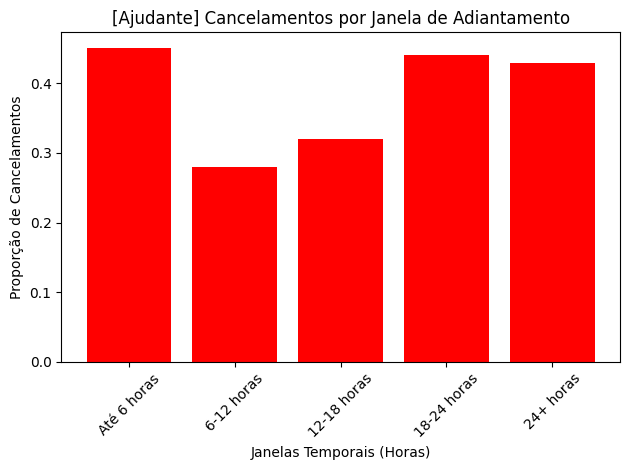

In [4]:
tipos_contrato = ['Diária', 'Coleta/Entrega', 'Ajudante']
timeline_file = 'src/data/timeline.csv'
days_file = 'src/data/days.csv'

for tipo in tipos_contrato:
    gerar_grafico_cancelamentos_por_adiamentos(timeline_file, days_file, tipo)
    gerar_grafico_ciclo_de_vida(timeline_file, days_file, tipo)
    gerar_grafico_distribuicao_adiamentos(timeline_file, days_file, tipo)
    gerar_grafico_proporcao_cancelamentos_por_adiantamento(timeline_file, days_file, tipo)
